## ВКР

Автоматизация подбора персонала

Копчев Владислав, БПМИ197

### Библиотеки

selenium поскольку нужен js

In [1]:
from bs4 import BeautifulSoup
import requests
import pandas as pd
from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import Select
# !pip install transliterate
from transliterate import translit
import re
import numpy as np

### Скрейпинг страницы со списком резюме

hh.ru не принимает названия с заглавными буквами:

In [126]:
def normalize_translit(ru_query):
    text = translit(ru_query, language_code='ru', reversed=True)
    text = text.replace(' ', '-').replace('yj', 'yy').replace('yy-', 'yy_').replace('es-', 'es_').replace('k-pr', 'k_pr')  # эвристическое правило, не знаю, почему у hh так...
    return text

In [192]:
driver = webdriver.Chrome('./chromedriver')

<ipython-input-192-c2e9cad52997>:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver')


In [65]:
def scrape(query, driver):
    # ищем кол-во страниц
    pages_count = 10  # соскрейпить это число иначе ошибки!
    link = 'https://hh.ru/resumes/{}?items_on_page=100&page={}'.format(query, 0)
    driver.get(link)
    
    pages_cnt_site = driver.find_elements(by=By.XPATH, value='//span[@class="pager-item-not-in-short-range"]/a[@class="bloko-button"][@rel="nofollow"][@data-qa="pager-page"]/span')
    if pages_cnt_site:
        pages_count = int(pages_cnt_site[-1].text)
        # print(pages_count)
    
    for n in range(pages_count):  # проблема!!
        link = 'https://hh.ru/resumes/{}?items_on_page=100&page={}'.format(query, n)  # 100 per page
        driver.get(link)

        resumes_list = driver.find_element(by=By.XPATH, value='//div[@class="resume-search-item__header"]')
        # resumes_list.click()  # стоп а зачем это...
        resumes = resumes_list.find_element(by=By.XPATH, value='//div[@data-qa="resume-serp__results-search"]').find_elements(by=By.XPATH, value='//a[@class="serp-item__title"]')

        resumes_parsed = []
        for x in resumes:
            resumes_parsed.append((x.text, x.get_attribute("href")))

        if n == 0:
            df = pd.DataFrame(resumes_parsed, columns=['Вакансия', 'Ссылка'])
            # print(len(resumes_parsed))
        else:
            # print(len(resumes_parsed))
            df2 = pd.DataFrame(resumes_parsed, columns=['Вакансия', 'Ссылка'])  # , index=list(range(0 + 100 * n, 100 + 100 * n)) n00, ..., n99n = 0, ..., 49
            df = pd.concat([df, df2])
    
    return df

<ipython-input-65-3541302dc275>:1: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  driver = webdriver.Chrome('./chromedriver')


In [66]:
analysts_list = ['аналитик bi',
                'системный аналитик',
                'бизнес аналитик',
                'аналитик продаж',
                'финансовый аналитик',
                'аналитик данных',
                'data analyst']
analysts_map = dict()

for analyst in analysts_list:
    analysts_map[analyst] = scrape(normalize_translit(analyst), driver)
    analysts_map[analyst].index = range(analysts_map[analyst].shape[0])

Конкатеннация результатов:

In [83]:
df1 = pd.DataFrame()

for analyst in analysts_list:
    df2 = analysts_map[analyst]
    df1 = pd.concat([df1, df2])
    
df1.index = range(df1.shape[0])
df1.to_csv('resumes_all.csv')

### Скрейпинг страницы с конкретным резюме

In [193]:
def normalize(x):
    if x:
        x = x[0].text
    else:
        x = '---'  # так будет лучше чем просто ' '?
    return x

In [201]:
inter2 = driver.find_elements(by=By.XPATH, value='//div[@data-qa="skills-table"]')
inter2[0].text

'Key skills\nAnalitical thinking\nEnglish\nOrganization Skills\nSAP\nMS SQL\nMS Outlook\nMS PowerPoint\nPower BI\nMS Excel'

In [202]:
def scrape(link, driver):
    driver.get(link)
    comandirovka = driver.find_elements(by=By.XPATH, value='//div[@class="bloko-translate-guard"]')
    comandirovka = normalize(comandirovka)  # норм?
    
    opyt = driver.find_elements(by=By.XPATH, value='//span[@class="resume-block__title-text resume-block__title-text_sub"]')
    opyt = normalize(opyt)

    about = driver.find_elements(by=By.XPATH, value='//div[@class="resume-block-container"][@data-qa="resume-block-skills-content"]')
    about = normalize(about)
        
    educ = driver.find_elements(by=By.XPATH, value='//div[@class="resume-block"][@data-qa="resume-block-education"]')
    educ = normalize(educ)
        
    inter = driver.find_elements(by=By.XPATH, value='//div[@class="resume-block-item-gap"]')
    inter = normalize(inter)
        
    #inter2 = driver.find_elements(by=By.XPATH, value='//div[@class="key-skills-row"][@data-qa="tags-key-skills"]')
    #inter2 = normalize(inter2)
    inter2 = driver.find_elements(by=By.XPATH, value='//div[@data-qa="skills-table"]')
    inter2 = normalize(inter2)
    
    # Образование; все написано не в том же стиле что и ^
    
    educ_val = '//div[@data-qa="resume-block-education"][@class="resume-block"]//div[@data-qa="resume-block-education-name"]'
    educ_ = driver.find_elements(by=By.XPATH, value=educ_val)
    stepen_val = '//div[@data-qa="resume-block-education"]//span[@class="resume-block__title-text resume-block__title-text_sub"]'
    stepen = driver.find_elements(by=By.XPATH, value=stepen_val)
    title_val = '//span[@class="resume-block__title-text"][@data-qa="resume-block-title-position"]'
    title = driver.find_elements(by=By.XPATH, value=title_val)
    if title:
        title = title[0].text
    else:
        title = ''
    
    educ1 = ''
    educ2 = ''
    educ3 = ''
    
    if educ_:
        educ1 = educ_[0].text
    if len(educ_) > 1:
        educ2 = educ_[1].text
    if stepen:
        educ3 = stepen[0].text
    vuzes_count = len(educ_)
    
    # Проблема: иногда уровень образования могут не писать
    
    # Работы
    work = driver.find_elements(by=By.XPATH, 
                             value='//div[@data-qa="resume-block-experience"][@class="resume-block"]//div[@class="resume-block-container"]')
    work1 = '---'
    work2 = '---'
    
    if len(work) > 0:
        work1 = work[0].text
    if len(work) > 1:
        work2 = work[1].text
    
    # EXPERIMENTAL: пробую собрать work
    work_list = []
    for w in work:
        work_list.append(w.text)
    work_count = len(work)
        
    return (link, title, comandirovka, opyt, about, educ, inter, inter2, educ1, educ2, 
            educ3, vuzes_count, work1, work2, work_list, work_count)

In [203]:
# driver = webdriver.Chrome('./chromedriver')

In [204]:
df_links = list(pd.read_csv('resumes_all.csv')['Ссылка'])[:300]  # rm [:300]

resume_list = []
for link in df_links:
    # print(link)
    data = scrape(link, driver)
    resume_list.append(data)

df = pd.DataFrame(resume_list, columns=['Ссылка',
                                        'Название',
                                        'Коммандировка', 
                                        'Опыт работы, лет',
                                        'О себе',
                                        'Образование',
                                        'Интересы',
                                        'Навыки',
                                        'Образование-1',
                                        'Образование-2',
                                        'Уровень образование',
                                        'Кол-во образований',
                                        'Работа 1',
                                        'Работа 2',
                                        'Где работал?',
                                        'Кол-во работ'])
df.to_csv('resumes_features.csv')
df.head(2)

KeyboardInterrupt: 

In [205]:
df = pd.DataFrame(resume_list, columns=['Ссылка',
                                        'Название',
                                        'Коммандировка', 
                                        'Опыт работы, лет',
                                        'О себе',
                                        'Образование',
                                        'Интересы',
                                        'Навыки',
                                        'Образование-1',
                                        'Образование-2',
                                        'Уровень образование',
                                        'Кол-во образований',
                                        'Работа 1',
                                        'Работа 2',
                                        'Где работал?',
                                        'Кол-во работ'])
df.to_csv('resumes_features.csv')
df.head(2)

,Ссылка,Название,Коммандировка,"Опыт работы, лет",О себе,Образование,Интересы,Навыки,Образование-1,Образование-2,Уровень образование,Кол-во образований,Работа 1,Работа 2,Где работал?,Кол-во работ
0,https://hh.ru/resume/1aa91e410000fd3cda0039ed1...,Analyst,"Moscow, willing to relocate, prepared for occa...",Work experience 7 years 4 months,"Responsible, communicable, quick study and det...",Higher education\n2015\nMOSCOW STATE UNIVERSIT...,"Specializations:\nSales manager, account manag...",Key skills\nAnalitical thinking\nEnglish\nOrga...,MOSCOW STATE UNIVERSITY OF MECHANICAL ENGINEER...,,Higher education,1,"NUTRICIA\nMoscow, nutricia.ru\nFood Products.....","Volkswagen Group Russia\nMoscow, www.volkswage...","[NUTRICIA\nMoscow, nutricia.ru\nFood Products....",4
1,https://hh.ru/resume/628596ac000657935b0039ed1...,BI аналитик,"Москва, не готова к переезду, готова к редким ...",Опыт работы 1 год 5 месяцев,В последние годы проходила обучение без возмож...,Высшее образование (Бакалавр)\n2022\nНациональ...,"Специализации:\nBI-аналитик, аналитик данных\n...",Ключевые навыки\nTableau\nPower BI\nSQL\nMS Ex...,"Национальный исследовательский университет ""Вы...",,Высшее образование (Бакалавр),1,"Ozon\nМладший аналитик\nСоздание, поддержка и ...",OZON\nСтажер группы BI аналитики и отчетности\...,"[Ozon\nМладший аналитик\nСоздание, поддержка и...",3


### Пост-обработка

In [3]:
df = pd.read_csv('resumes_features.csv')

**Перевод опыта работы в числовое значение:**

In [4]:
df['Опыт работы, лет'][2]
opyt_normalized = []
for x in df['Опыт работы, лет']:
    x=x.removeprefix('Work experience ').removeprefix('Опыт работы ')
    x=x.replace('years', ';')
    x=x.replace('year', ';')
    x=x.replace('года', ';')  # ВСЕГДА д. б. раньше
    x=x.replace('год', ';')
    x=x.replace('лет', ';')
    
    if x.find(';') == -1:
        x = '0;' + x
    x=x.removesuffix('months')
    x=x.removesuffix('month')
    x=x.removesuffix('месяцев')
    x=x.removesuffix('месяц')
    x=x.removesuffix('месяца')
     
    x=x.replace(' ', '')
    if re.search('[а–Я]+|[a–Z]+', x):
        x='---'
    opyt_normalized.append(x)
    
df['Опыт нормализованный'] = opyt_normalized
df.drop(list(df)[0], axis=1)

,Unnamed: 0.1,Unnamed: 0.1.1,Ссылка,Название,Коммандировка,"Опыт работы, лет",О себе,Образование,Интересы,Навыки,...,Где работал?,Кол-во работ,Опыт нормализованный,Топовость образования,is_eng?,Уровень оборазования нормализованный,Навыки списком,Релокация?,Коммандировка?,Город?
0,0,0,https://hh.ru/resume/1aa91e410000fd3cda0039ed1...,Analyst,"Moscow, willing to relocate, prepared for occa...",Work experience 7 years 4 months,"Responsible, communicable, quick study and det...",Higher education\n2015\nMOSCOW STATE UNIVERSIT...,"Specializations:\nSales manager, account manag...",Key skills\nAnalitical thinking\nEnglish\nOrga...,...,"['NUTRICIA\nMoscow, nutricia.ru\nFood Products...",4,7;4,False,RU,Высшее образование,"['Key skills', 'Analitical thinking', 'English...",prepared for occasional business trips,willing to relocate,Moscow
1,1,1,https://hh.ru/resume/628596ac000657935b0039ed1...,BI аналитик,"Москва, не готова к переезду, готова к редким ...",Опыт работы 1 год 5 месяцев,В последние годы проходила обучение без возмож...,Высшее образование (Бакалавр)\n2022\nНациональ...,"Специализации:\nBI-аналитик, аналитик данных\n...",Ключевые навыки\nTableau\nPower BI\nSQL\nMS Ex...,...,"['Ozon\nМладший аналитик\nСоздание, поддержка ...",3,1;5,True,ENG,Бакалавр,"['Ключевые навыки', 'Tableau', 'Power BI', 'SQ...",NaN,NaN,NaN
2,2,2,https://hh.ru/resume/dfbcae000004342d8f0039ed1...,BI аналитик,"Москва, не готова к переезду, готова к команди...",Опыт работы 3 года 3 месяца,---,Высшее образование (Бакалавр)\n2019\nСамарский...,"Специализации:\nBI-аналитик, аналитик данных\n...",Ключевые навыки\nPython\nSQL\nУмение работать ...,...,"['Банк ВТБ (ПАО)\nМосква, www.vtbcareer.com\nФ...",1,3;3,False,ENG,Бакалавр,"['Ключевые навыки', 'Python', 'SQL', 'Умение р...",NaN,NaN,NaN
3,3,3,https://hh.ru/resume/bebf6a630008069d8c0039ed1...,Аналитик,"Санкт-Петербург, м. Гражданский проспект, гото...",Опыт работы 7 лет 2 месяца,Имею экономическое образование. Продвинутый по...,Высшее образование (Бакалавр)\n2015\nСанкт-Пет...,Специализации:\nАналитик\nЗанятость: полная за...,Ключевые навыки\nЭкономический анализ\nЭкономи...,...,['A&D Mortgage\nСтарший BI аналитик\nСоздание ...,6,7;2,False,ENG,Бакалавр,"['Ключевые навыки', 'Экономический анализ', 'Э...",NaN,NaN,NaN
4,4,4,https://hh.ru/resume/8606f37b000773de980039ed1...,Программист-разработчик,"Москва, м. Петровско-Разумовская, не готов к п...",Опыт работы 1 год 1 месяц,Имеется опыт в создании Android-приложений на ...,Высшее образование (Бакалавр)\n2022\nЧелябинск...,"Специализации:\nПрограммист, разработчик\nЗаня...",Ключевые навыки\nАдминистрирование серверов Li...,...,['MoneyCare\nBI-аналитик\nРабота с big data(Py...,1,1;1,False,RU,Бакалавр,"['Ключевые навыки', 'Администрирование серверо...",NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193,193,193,https://hh.ru/resume/9024b1760002f0f0fe0039ed1...,Business analyst,"Moscow, metro station Akademicheskaya, willing...",Work experience 5 years 5 months,An interest in investment and economics led my...,Higher education (bachelor)\n2017\nBrunel univ...,Specializations:\nAnalyst\nEmployment: full ti...,Key skills\nAnalytical skills\nSAP PM\nBusines...,...,['SMARTSEEDS\nБизнес-аналитик\n• Support of so...,3,5;5,False,RU,Бакалавр,"['Key skills', 'Analytical skills', 'SAP PM', ...",NaN,willing to relocate,Moscow
194,194,194,https://hh.ru/resume/c0d0ac9b0002b4446d0039ed1...,Аналитик,"Москва, м. Планерная, не готов к переезду, не ...",Опыт работы 5 лет,Проходил иностранное обучение в Kaplan Interna...,Высшее образование\n2015\nРоссийский экономиче...,Специализации:\nАналитик\nЗанятость: стажировк...,Ключевые навыки\nАнглийский язык\nРабота в ком...,...,"['Керхер, ООО\nМосква, www.karcher.ru\nЭлектро...",4,5;,False,RU,Высшее образование,"['Ключевые навыки', 'Английский язык', 'Работа...",NaN,NaN,NaN
195,195,195,https://hh.ru/resume/8b2d7d4700092277b60039ed1...,Product Analyst,"Москва, м. Текстильщики, готов к переезду,

**Словарь образования:**

In [5]:
edu_list = pd.concat([df['Образование-1'], df['Образование-2']], axis=0).drop_duplicates().reset_index().drop('index', axis=1)
edu_list = list(edu_list[list(edu_list)[0]])
len(edu_list)

ys=[]

for x in edu_list:
    s=str(x)
    l = s.find(',')+1
    y=s[l:].lstrip(' ')
    print(end='')
    ys.append(y)
    
for i in range(len(ys)):
    y = ys[i]
    is_space = re.fullmatch('[А-я]+[ ][А-я ()-]+', y)
    if is_space:
        #print(y)
        1==1
    is_m = re.fullmatch('Mosc.*', y) or re.fullmatch('Моск.*', y) or re.fullmatch('Петерб.*', y) or re.fullmatch('Peters.*', y) or re.fullmatch('СПб.*', y) or re.fullmatch('Новосиб.*', y) or re.fullmatch('Novosib.*', y) or re.fullmatch('Томск.*', y) or re.fullmatch('Tomsk.*', y)
    if not is_space and not is_m:
        ys[i] = 'NO'
#ys

cnt=0
for y in ys:
    if y != 'NO':
        cnt+=1
cnt

import numpy as np
ys = np.array(ys)
ys=np.unique(ys)
ys=list(ys)
len(ys)

"""
Топ-10 IT-вузов России по версии QS (Quacquarelli Symonds)

1. Московский государственный университет им. М. В. Ломоносова;
2. Университет ИТМО;
3. Московский физико-технологический институт (МФТИ);
4. Высшая школа экономики;
5. Санкт-Петербургский политехнический университет Петра Великого; 
6. Московский государственный технический университета (МГТУ) имени Н.Э. Баумана;
7. Санкт-Петербургский политехнический университет Петра Великого; 
8. Новосибирский государственный университет;
9. Московский инженерно-физический институт (МИФИ);
10. Томский политехнический университет.

https://propostuplenie.ru/article/spisok-luchshih-informacionnyh-vuzov-rossii/
"""

def is_top(y):
    if re.search('ВШЭ', y) or re.search('Высшая школа экономики', y) or re.search('HSE', y):
        y='ВШЭ'
    elif re.search('Московский Государственный Университет$', y) or re.search('Московский Государственный Университет им[.  ени] (М.|Л)', y) or re.search('МГУ[^ А-я]|\(МГУ\)', y) or re.search('Moscow state University', y) or re.search('MSU', y):
        y='МГУ'
    elif re.search('ИТМО', y):
        y='ИТМО'
    elif re.search('МФТИ', y) or re.search('Московский физико-технологический институт', y):
        y='Физтех'
        # ЗФТШ при МФТИ
        # - Физтех
    elif re.search('СПБ Политех', y) or re.search('Санкт-Петербургский политехнический университет', y):
        y='Политех СПб'
    elif re.search('Бауман', y):
        y='Бауманка'
    elif re.search('НГУ', y) or re.search('Новосибирский государственный университет', y):
        y='НГУ'
        # НГУ Наталии Нестеровой
    elif re.search('МИФИ', y) or re.search('Московский инженерно-физический институт', y):
        y='МИФИ'
        # Какие-то Техникум ДИТИ НИЯУ МИФИ и прочее...
    elif re.search('ТомГУ', y) or re.search('Томский политехнический университет', y):
        y='ТомГУ'
    else:
        y='NO'
    return y != 'NO'
        
# Дальше завожу колонку: parsed_uni по этому правилу -- 1 если хотя бы 1 уник топовый
# И там заменяю значения и вывожу равно ли МГУ / етц.

xs = []
for x in df.index:
    stroke = df.iloc[x].loc[['Образование-1', 'Образование-2']]
    k2 = False
    if type(stroke[0]) != float:
        k1 = is_top(stroke[0])
    if type(stroke[1]) != float:
        k2 = is_top(stroke[1])
    xs.append(k1 or k2)
    
df['Топовость образования']=xs

Необходимо еще доделать правила:

In [6]:
is_top('МГУ') # почему-то не работает
# for x in 

False

**Флаг, что текст на eng:**

In [7]:
df['О себе']
cnt=0

for y in df['О себе']:
    if type(y)!=float:  # not nan
        if re.search('[a–Z]+', y):  # более точно: у английских резюме интересы тоже будут на англ итд, потом подумаю над этим
            cnt+=1
cnt, df.shape[0]-cnt

ts=[]
for x in df['О себе']:
    t = 'NOT ENG, NOT RU'
    if type(x)!=float:  # not nan
        t = re.search('[a–Z]+', x)
        if t:
            t = 'ENG'
        else:
            t = 'RU'
    ts.append(t)
df['is_eng?'] = ts

**Справочник по интересам:**

In [112]:
inter_list = []

for inter in df['Интересы']:
    intr = inter.split('\n')
    if re.search('(Analyst)|(Аналитик данных)|(аналитик)|(Аналитик)', inter):
        inter_list.append('found smt by rule (Analyst)|(Аналитик данных)|(аналитик)|(Аналитик)')
    else:
        inter_list.append('---')
        
df['Справочник по интересам']= inter_list

**Извлечение сущностей:**

In [102]:
xs1 = []
xs2=[]
xs3=[]
for x in df['Коммандировка']:
    # english
    x1 = re.search('[A-z]+', x)
    x2 = re.search('[a-z ]*willing to relocate', x)
    x3 = re.search('[a-z ]*prepared for [a-z]* business trips', x)
    if x1:
        x1=x1[0]
    if x2:
        x2=x2[0]
    if x3:
        x3=x3[0]
    
    if x1 or x2 or x3:  # if found smt in engish — is it not wrong way to do it?
        xs1.append(x1)
        xs2.append(x2)
        xs3.append(x3)
    else:
        # russian — work in progress
        # Москва, не готова к переезду, готова к редким командировкам
        # Санкт-Петербург, м. Гражданский проспект, готов к переезду (Москва), готов к командировкам
        # Москва, готов к переезду (Нидерланды, Испания, Франция, Италия, Австрия, Германия, Швейцария), готов к командировкам
        # Москва, хочу переехать, готов к командировкам
        # Москва, м. Ясенево, не готов к переезду, готов к редким командировкам
        x1 = re.search('[А-я]+', x)  # is it correct?
        x2 = re.search('[А-я]*[ не]*готов[а]* к переезду', x)
        x3 = re.search('[А-я]*[ не]*готов[а]* к[ а-я]* командировкам', x)  # черновое правило
        if x1:
            x1=x1[0]
        if x2:
            x2=x2[0]
        if x3:
            x3=x3[0]
        xs1.append(x1)
        xs2.append(x2)
        xs3.append(x3)

zs = []
for z in df['Навыки']:
    zzz = z.split('\n')
    zs.append(zzz)
    
df['Навыки списком'] = zs
df['Релокация?'] = xs3
df['Коммандировка?'] = xs2
df['Город?'] = xs1

"""
1. Коммандировка 
2. Навыки
3. Кол-во работ
4. Наличие аналитических комбинаций слов в работе — новый столбец
"""

import numpy as np
df['Коммандировка'][8]

# (не) готов -> (не) готова
# (not) willing, (not) preprared

# City, (not willing)., (not) prepared

import re

print(df['Коммандировка'][8])
print(re.search('[A-z]+', df['Коммандировка'][8]))
print(re.search('[a-z ]*willing to relocate', df['Коммандировка'][8]))
print(re.search('[a-z ]*prepared for business trips', df['Коммандировка'][8]))

print(df['Коммандировка'][0])
print(re.search('[A-z]+', df['Коммандировка'][0]))
print(re.search('[a-z ]*willing to relocate', df['Коммандировка'][0]))
print(re.search('[a-z ]*prepared for [a-z]* business trips', df['Коммандировка'][0]))
# ^ оказывается есть еще occasional
# тогда для eng-коммандировки готово!

# Коммандировка более-менее есть. Теперь навыки. 

df['Навыки'][0].split('\n')  # вот так?

# Навыки есть. Теперь кол-во работ. Для этого соскрейпить все работы и их кол-во

df

# У меня уже скрейпится список всех работ. Надо его добавить просто а не только 12!!

# Все вроде я это собрал

# Теперь наличие аналитических комбинаций слов в работе. Для этого сначала сделать 3 пункт!!

# Кол-во работ сделано. Итак:

work_list = df['Где работал?']
analytics_words = []
for work in work_list:
    # пока супер примитивное правило:
    if re.search('(SQL)|(Excel)|(Python)|(Tableau)|(Power BI)', work):
        analytics_words.append('found smt by rule (SQL)|(Excel)|(Python)|(Tableau)|(Power BI)')
    else:
        analytics_words.append('---')
df['Аналитические комбинации слов'] = analytics_words

Moscow, not willing to relocate, prepared for business trips
<re.Match object; span=(0, 6), match='Moscow'>
<re.Match object; span=(7, 31), match=' not willing to relocate'>
<re.Match object; span=(32, 60), match=' prepared for business trips'>
Moscow, willing to relocate, prepared for occasional business trips
<re.Match object; span=(0, 6), match='Moscow'>
<re.Match object; span=(7, 27), match=' willing to relocate'>
<re.Match object; span=(28, 67), match=' prepared for occasional business trips'>


**Перевод уровня образования:**

In [103]:
z = list(np.unique(list(df['Уровень образование'])))

for y in z:
    y=y.removeprefix('Higher education ')
    y=y.replace('(', '').replace(')', '')
    y=y.replace('bachelor', 'Бакалавр').replace('master', 'Магистр')
    y=y.replace('Doctor of Science', 'PhD').replace('PhD', 'Доктор наук')
    
    y=y.removeprefix('Высшее образование ')
    y=y.replace('Higher education', 'Высшее образование')
    y=y.replace('Incomplete higher education', 'Неоконченное высшее образование')
    y=y.replace('Secondary education', 'Среднее образование')
    y=y.replace('Secondary special education', 'Среднее специальное образование')
    print(y)
    
ys=[]
for y in df['Уровень образование']:
    y=y.removeprefix('Higher education ')
    y=y.replace('(', '').replace(')', '')
    y=y.replace('bachelor', 'Бакалавр').replace('master', 'Магистр')
    y=y.replace('Doctor of Science', 'PhD').replace('PhD', 'Доктор наук')
    
    y=y.removeprefix('Высшее образование ')
    y=y.replace('Higher education', 'Высшее образование')
    y=y.replace('Incomplete higher education', 'Неоконченное высшее образование')
    y=y.replace('Secondary education', 'Среднее образование')
    y=y.replace('Secondary special education', 'Среднее специальное образование')
    ys.append(y)
df['Уровень оборазования нормализованный'] = ys

Высшее образование
Бакалавр
Магистр
Высшее образование
Бакалавр
Магистр
Неоконченное высшее образование
Среднее специальное образование


**Сохранение результатов:**

In [123]:
list(df)[:6]

['Ссылка',
 'Название',
 'Коммандировка',
 'Опыт работы, лет',
 'О себе',
 'Образование']

In [122]:
# df=df.drop(list(df)[0], axis=1)

In [124]:
df.to_csv('resumes_features.csv')

## Черновик

Осталось доделать справочник по образованию еще лучше, а также справочник по интересам и наличие аналитчиеских комбинаций слов (см черновик, что сделать)

In [12]:
# concatennate tables

# df1 = read_csv(resumes_features)

# df2 = gather_data(driver)

# df3 = pd.concat([df1, df2]).drop_duplicates

# !mv resumes_features/backup/cur_date/resumes_features

# df3.to_csv(resumes_features)

**начинаем АД:**

In [2]:
df = pd.read_csv('resumes_features.csv')

In [4]:
about = df['О себе']

In [6]:
about

0      Responsible, communicable, quick study and det...
1      В последние годы проходила обучение без возмож...
2                                                    ---
3      Имею экономическое образование. Продвинутый по...
4      Имеется опыт в создании Android-приложений на ...
                             ...                        
193    An interest in investment and economics led my...
194    Проходил иностранное обучение в Kaplan Interna...
195    Стек технологий:\n[Имеется опыт]: Excel, Oracl...
196    - Обладаю аналитическим складом ума, способен ...
197    В резюме отражены последние четыре места работ...
Name: О себе, Length: 198, dtype: object

ключевые совпадения см л34 она скинула

**Извлечение сущностей: более соершенные правила.** ВКР. Если город и коммандировка на английском то резюме точно на английском. Какие-то такие правила еще поискать. Посмотрю только в каком таком точном поле меньше всего пропусков. ВКР: позже вычленяю ещё сущности как она сказала см prev call в 7.12. См github: допилить еще справочник образования и прочее, чтобы все в этом плане было идеально

embeddings:

- tf-idf: важность слов (вектор = мера важности каждого слова в документе через запятую)

- word2vec и BERT: учиытвают семантические особенности

Курс по тектсовой аналитике с Я.Диска не так полезен как https://stepik.org/course/129443/promo но я пока не смотрел

см еще статьи в папке 7.12

Реализация w2v https://towardsdatascience.com/a-word2vec-implementation-using-numpy-and-python-d256cf0e5f28

lib: https://radimrehurek.com/gensim/models/word2vec.html (потом пойму в чем ограничения)

In [11]:
about_small = about[:10]

In [12]:
about_small

0    Responsible, communicable, quick study and det...
1    В последние годы проходила обучение без возмож...
2                                                  ---
3    Имею экономическое образование. Продвинутый по...
4    Имеется опыт в создании Android-приложений на ...
5    Уверенный пользователь.\nЖелание оптимизации и...
6                                   Academic IELTS 8.0
7    1) В 2021 году закончил с отличием программу д...
8    2015-2016 - the teacher of the Small Mechmath ...
9    Data Analytics with Visual Basic for Applicati...
Name: О себе, dtype: object

In [14]:
about_small_tokens = []

for text in about_small:
    about_small_tokens.append(text.split(' '))

In [9]:
from gensim.test.utils import common_texts
from gensim.models import Word2Vec

In [10]:
common_texts

[['human', 'interface', 'computer'],
 ['survey', 'user', 'computer', 'system', 'response', 'time'],
 ['eps', 'user', 'interface', 'system'],
 ['system', 'human', 'system', 'eps'],
 ['user', 'response', 'time'],
 ['trees'],
 ['graph', 'trees'],
 ['graph', 'minors', 'trees'],
 ['graph', 'minors', 'survey']]

In [16]:
about_small_tokens[0]

['Responsible,', 'communicable,', 'quick', 'study', 'and', 'detail-oriented']

In [19]:
model = Word2Vec(sentences=about_small_tokens, vector_size=100, window=5, min_count=1, workers=4)
model.save("word2vec.model")

In [20]:
model = Word2Vec.load("word2vec.model")

In [21]:
model

In [22]:
about_small2 = about[10:20]

In [23]:
about_small2

10    Неплохой аналитик данных создаст витрины и пон...
11    Ключевые знания и навыки:\nКачественный анализ...
12    - Python, SQL, BI (PowerBI, Tableau, Apache Su...
13    Свободное владение компьютером. (MS Office/Exc...
14    За время работы и учёбы, я овладел компетенция...
15                                                  ---
16    Увлекаюсь фондовым рынком, торгую, пишу аналит...
17    Участвовал в кейс чемпионатах British American...
18                                                  ---
19                                                  ---
Name: О себе, dtype: object

In [24]:
about_small_tokens2 = []

for text in about_small2:
    about_small_tokens2.append(text.split(' '))

In [26]:
about_small_tokens2[-1]

['---']

In [27]:
model.train(about_small_tokens2, total_examples=len(about_small_tokens2), epochs=1)

(53, 488)

In [32]:
about_small_tokens2[0]

['Неплохой',
 'аналитик',
 'данных',
 'создаст',
 'витрины',
 'и',
 'понятные',
 'дашборды,',
 'раскрывающие',
 'текущую',
 'ситуацию',
 'и',
 'помощающие',
 'выявить',
 'неочевидные',
 'зависимости.']

^ наверное лучше еще привести все токены в тексте к норм. форме?

In [44]:
vector = model.wv['данных']  # get numpy vector of a word
sims = model.wv.most_similar('данных', topn=10)  # get other similar words

^ почему для слова аналитик не работает? какие слова есть?

In [55]:
model.wv['аналитик']

KeyError: "Key 'аналитик' not present"

In [58]:
model.wv.key_to_index

{'и': 0,
 'в': 1,
 'на': 2,
 'с': 3,
 'опыт': 4,
 'of': 5,
 'В': 6,
 'по': 7,
 'the': 8,
 'данных': 9,
 'работы': 10,
 'году': 11,
 'and': 12,
 'а': 13,
 'Python,': 14,
 'пользуюсь': 15,
 'системы': 16,
 'Microsoft': 17,
 'данных,': 18,
 '(': 19,
 'момент': 20,
 'данный': 21,
 'офисных': 22,
 '-': 23,
 'двух': 24,
 'London': 25,
 'SQL,': 26,
 '2021': 27,
 'работа': 28,
 'Android-приложений': 29,
 'этих': 30,
 'основами': 31,
 'обладаю': 32,
 'вследствие': 33,
 'создании': 34,
 'нахожусь': 35,
 'языке': 36,
 'чат-бот': 37,
 'аналитический': 38,
 'Git.\n\nCоздал': 39,
 'Docker': 40,
 'скриптов': 41,
 'Kotlin,': 42,
 'территории': 43,
 'сервисов': 44,
 'различных': 45,
 'веб-сервисов': 46,
 'Java': 47,
 'Имеется': 48,
 'РФ.': 49,
 'Asp.Net,': 50,
 'вёрстки': 51,
 'технологий': 52,
 'HTML+CSS+JS,': 53,
 'дальнейшем': 54,
 'разработки.\n\nИмеется': 55,
 'командной': 56,
 'переговоров,': 57,
 'презентаций': 58,
 'использую': 59,
 'их': 60,
 'заказчиками.\n\nСсылка': 61,
 'мой': 62,
 'github:

In [64]:
dict(model.wv.key_to_index)

{'и': 0,
 'в': 1,
 'на': 2,
 'с': 3,
 'опыт': 4,
 'of': 5,
 'В': 6,
 'по': 7,
 'the': 8,
 'данных': 9,
 'работы': 10,
 'году': 11,
 'and': 12,
 'а': 13,
 'Python,': 14,
 'пользуюсь': 15,
 'системы': 16,
 'Microsoft': 17,
 'данных,': 18,
 '(': 19,
 'момент': 20,
 'данный': 21,
 'офисных': 22,
 '-': 23,
 'двух': 24,
 'London': 25,
 'SQL,': 26,
 '2021': 27,
 'работа': 28,
 'Android-приложений': 29,
 'этих': 30,
 'основами': 31,
 'обладаю': 32,
 'вследствие': 33,
 'создании': 34,
 'нахожусь': 35,
 'языке': 36,
 'чат-бот': 37,
 'аналитический': 38,
 'Git.\n\nCоздал': 39,
 'Docker': 40,
 'скриптов': 41,
 'Kotlin,': 42,
 'территории': 43,
 'сервисов': 44,
 'различных': 45,
 'веб-сервисов': 46,
 'Java': 47,
 'Имеется': 48,
 'РФ.': 49,
 'Asp.Net,': 50,
 'вёрстки': 51,
 'технологий': 52,
 'HTML+CSS+JS,': 53,
 'дальнейшем': 54,
 'разработки.\n\nИмеется': 55,
 'командной': 56,
 'переговоров,': 57,
 'презентаций': 58,
 'использую': 59,
 'их': 60,
 'заказчиками.\n\nСсылка': 61,
 'мой': 62,
 'github:

^ словарь

In [56]:
sims

[('английском', 0.31356385350227356),
 ('9.\nВ', 0.2540714740753174),
 ('HTML+CSS+JS,', 0.24981936812400818),
 ('JavaScript\n-', 0.2405378371477127),
 ('формализации', 0.23670218884944916),
 ('и', 0.21834993362426758),
 ('сервисов', 0.2158057987689972),
 ('оптимизации', 0.20735448598861694),
 ('School', 0.1881561428308487),
 ('себя', 0.1830604374408722)]

пересечения:

In [95]:
a = about_small_tokens2
un = list(set().union(*a))

# https://stackoverflow.com/questions/30773911/union-of-multiple-sets-in-python

In [105]:
setlist = []
for s in a:
    setlist.append(set(s))

In [107]:
setlist[0]

{'Неплохой',
 'аналитик',
 'витрины',
 'выявить',
 'данных',
 'дашборды,',
 'зависимости.',
 'и',
 'неочевидные',
 'помощающие',
 'понятные',
 'раскрывающие',
 'ситуацию',
 'создаст',
 'текущую'}

In [110]:
u = set.intersection(*setlist)

In [111]:
len(model.wv.key_to_index.keys())

313

In [112]:
len(u)

0

In [113]:
u

set()

сделаю как тут https://towardsdatascience.com/using-word2vec-to-analyze-news-headlines-and-predict-article-success-cdeda5f14751

In [68]:
pd.DataFrame(dict(model.wv.key_to_index).values(), index=dict(model.wv.key_to_index).keys())

,0
и,0
в,1
на,2
с,3
опыт,4
...,...
остальных,308
программ,309
MS,310
"Office,",311


In [69]:
d=dict()

In [70]:
for x in model.wv.key_to_index:
    d[x] = model.wv[x]

In [76]:
df = pd.DataFrame(d.values(), index=d.keys())

In [77]:
from sklearn.manifold import TSNE

# Initialize t-SNE
tsne = TSNE(n_components = 2, init = 'random', random_state = 10, perplexity = 100)

# Use only 400 rows to shorten processing time
tsne_df = tsne.fit_transform(df[:400])

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

In [83]:
#!pip install adjustText

  Created wheel for adjustText: filename=adjustText-0.7.3-py3-none-any.whl size=7098 sha256=a8b3d0dea7f763da414ae68eab29e13f0455d5c8e8d2ab3803f923aade46551e
  Stored in directory: /Users/vladkopchev/Library/Caches/pip/wheels/6b/1d/79/4326d5f3a7d86fb9900e5564e7a0f98b552da5103ca762f24f
Successfully built adjustText


In [87]:
tsne_df0 = tsne_df
tsne_df = tsne_df[:10]

/Users/vladkopchev/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


IndexError: index 10 is out of bounds for axis 0 with size 10

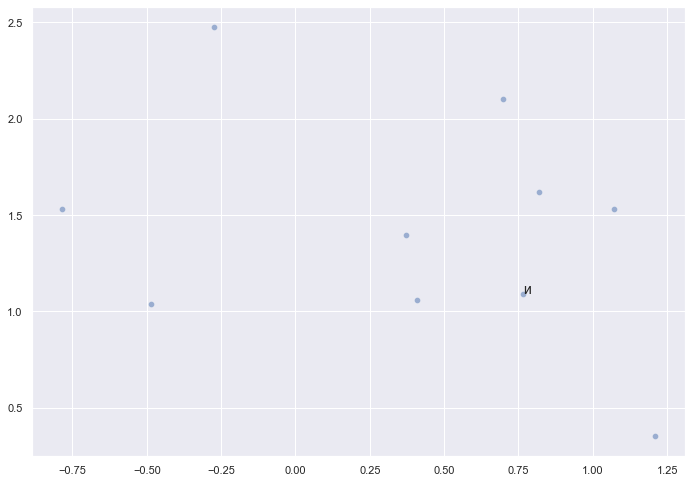

In [88]:
sns.set()
# Initialize figure
fig, ax = plt.subplots(figsize = (11.7, 8.27))
sns.scatterplot(tsne_df[:, 0], tsne_df[:, 1], alpha = 0.5)

# Import adjustText, initialize list of texts
from adjustText import adjust_text
texts = []
words_to_plot = list(np.arange(0, 400, 10))

# Append words to list
for word in words_to_plot:
    texts.append(plt.text(tsne_df[word, 0], tsne_df[word, 1], df.index[word], fontsize = 14))
    
# Plot text using adjust_text (because overlapping text is hard to read)
adjust_text(texts, force_points = 0.4, force_text = 0.4, 
            expand_points = (2,1), expand_text = (1,2),
            arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))

plt.show()

NameError: name 'main_data' is not defined

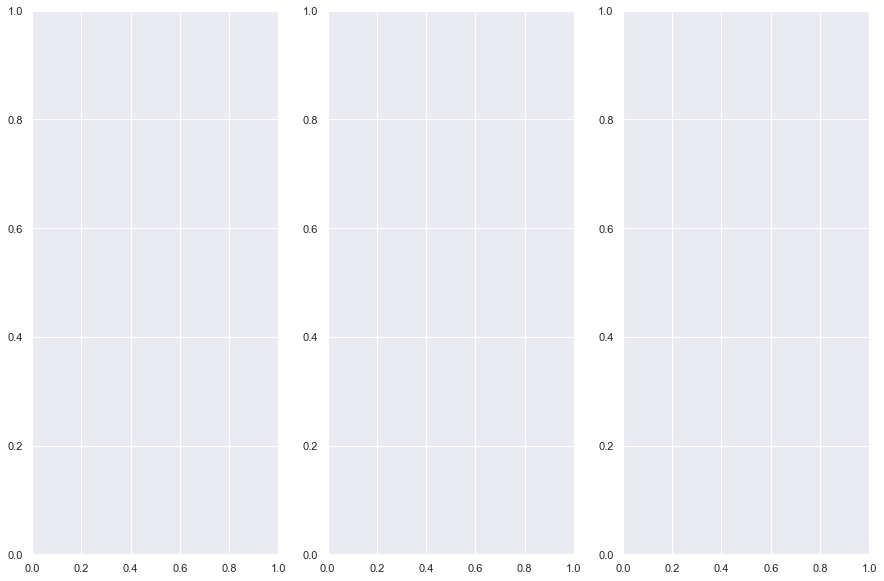

In [89]:
fig, ax = plt.subplots(1, 3, figsize=(15, 10))

subplots = [a for a in ax]
platforms = ['Facebook', 'GooglePlus', 'LinkedIn']
colors = list(sns.husl_palette(10, h=.5)[1:4]) 

for platform, subplot, color in zip(platforms, subplots, colors):
    sns.scatterplot(x = main_data[platform], y = main_data['SentimentTitle'], ax=subplot, color=color)
    subplot.set_title(platform, fontsize=18)
    subplot.set_xlabel('') 
    
fig.suptitle('Plot of Popularity (Shares) by Title Sentiment', fontsize=24)

plt.show()